# Char RNN

En esta notebook, haremos un clasificador en base a caracteres



In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))




Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


Primero, entrenemos una LSTM para caracteres

In [2]:
from hate.nn import Tokenizer
tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

tokenizer = Tokenizer(**tokenize_args)

text_train = [" ".join(tokenizer.tokenize(t)) for t in df_train["text"].values]
text_dev = [" ".join(tokenizer.tokenize(t)) for t in df_dev["text"].values]



Using TensorFlow backend.


Probemos haciendo stemming primero

In [3]:
from keras.preprocessing.text import Tokenizer as KerasTokenizer

vocab_size = 200
char_tokenizer = KerasTokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

char_train = char_tokenizer.texts_to_sequences(text_train)
char_dev = char_tokenizer.texts_to_sequences(text_dev)

In [4]:
print("Cantidad de tokens total: {}".format(len(char_tokenizer.word_index)))
print("Nos quedamos con {}".format(vocab_size))

Cantidad de tokens total: 320
Nos quedamos con 200


Hagamos un histograma de la cantidad de caracteres primero


(array([358., 909., 892., 800., 492., 273., 257., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

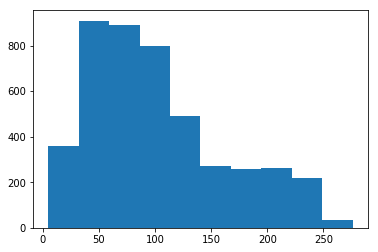

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in text_train])

Cortemos en 250

In [6]:
import numpy as np

max_charlen = 250


Hagamos un primer modelo con múltiple inputs.

In [7]:
from hate.nn import CharModel
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.001,
    "decay": 0.001,
}

embedding_dim = 150


model = CharModel(vocab_size=vocab_size, max_charlen=max_charlen, 
                  tokenize_args=tokenize_args)
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit(text_train, y_train, validation_data=(text_dev, y_dev), epochs=15, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 18s 4ms/step - loss: 0.6800 - acc: 0.5840 - val_loss: 0.6845 - val_acc: 0.5560
Epoch 2/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.6549 - acc: 0.6162 - val_loss: 0.6679 - val_acc: 0.5860
Epoch 3/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.6237 - acc: 0.6638 - val_loss: 0.6269 - val_acc: 0.6480
Epoch 4/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5672 - acc: 0.7160 - val_loss: 0.6568 - val_acc: 0.6780
Epoch 5/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5202 - acc: 0.7547 - val_loss: 0.5963 - val_acc: 0.6860
Epoch 6/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.4853 - acc: 0.7749 - val_loss: 0.5668 - val_acc: 0.7280
Epoch 7/15
4500/4500 [==============================] - 17s 4ms/step - loss: 0.4515 - acc: 0.8087 - val_loss: 0.5791 - val_acc: 0.7140
Epoch 8/

In [9]:
from hate.utils import print_evaluation

print_evaluation(model, X_char_dev, y_dev)

ModuleNotFoundError: No module named 'sklearn'

No parece mejorar mucho stemming

## Error Analysis

Vamos a ver los tweets con mayores errores

In [16]:
df_dev["proba"] = model.predict_proba(X_char_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 45
Falsos positivos: 61


,pred_true,pred_false
real,,
hs=1,177,45
hs=0,61,217


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [17]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.001557
22328,"@EvaMari86958216 @alex_UCM1 Yo también creo que tú eres una mala puta y también me quedo corto, además de mal educada...",0.005359
23783,Lo mejor de todo ver a Anabel con cara de asco jeje fijo que te lo mereces zorra https://t.co/3MMQKUAWYG,0.005577
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.007759
21297,@valevitarb es que tú eres LA perra MAYOR 🐕✨✨✨✨✨,0.020126
24434,"""Hace tanto calor que podría matar a un árabe indiferentemente. (Referencia de """"El extranjero"""")""",0.023323
24895,"@xSuzuHopkins @gimme5yens El de mi polla a granel. Que te calles, virgen.",0.027346
22592,o sea tantos arabes q hay en venezuela y no pueden hacer un atentado decente q pasa ?????????,0.028854
22953,Le puedes dar un pez a un hombre y comerá un día Como le des una caña a un subsahariano fabricará una lanza y atravesará a un guardia civil,0.041712


¿Cómo los tokenizamos?

In [20]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Elmo y OOV words

¿Qué hace elmo con palabras extrañas como "negratas", "subsaharianos", etc?

In [59]:
vocabulary = e.word_lexicon.keys()

"negratas" in vocabulary

False

In [60]:
"subsahariano" in vocabulary

False

Ok. Estamos perdiendo información con esto

In [51]:
vecs = e.sents2elmo([["negratas"], ["subsahariano"]], 2)

In [52]:
vecs[0].shape, vecs[1].shape

((1, 1024), (1, 1024))

In [57]:
v1 = vecs[0].reshape(-1)
v2 = vecs[1].reshape(-1)

sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

sim

0.7698738

## Falsos negativos

In [63]:
pd.set_option('max_colwidth', 200)
false_positives[["text", "proba"]]

,text,proba
id,,
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.958672
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.955924
21966,"escúchame ya me jodería jajajajajajajajajajajajajaja si pa ti enseñar es ser una guarra yo soy biennnn guarra, menos mal que no me respeto que si no... https://t.co/yt5fHp99b7",0.946862
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.944250
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.941651
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.930660
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.920149
24529,@desoir2525 Cállate rata MUDera.eres escoria.,0.908138
21892,@saancisco Callate puta tu eres el traidor.,0.878067


## Usando las traducciones?

Probemos, ya que estamos...

# Conclusiones

Sirvió mejorar el preprocesamiento. Quedamos en pérdida ~0.43

No estarían convenciendo las traducciones...

Diría que intentemos un ensemble con caracteres o n-gramas.